In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.integrate as scpi

import os 

import cbmos
import cbmos.force_functions as ff
import cbmos.solvers.euler_forward as ef
import cbmos.cell as cl

plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6.75, 5),
          'lines.linewidth': 3.0, 
          'axes.labelsize': 'xx-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'xx-large', 
          'ytick.labelsize':'xx-large', 
          'legend.fontsize': 'xx-large', 
          'font.size': 11, 
          'font.family': 'serif', 
          'mathtext.fontset': 'dejavuserif', 
          'axes.titlepad': 12, 
          'axes.labelpad': 12}
plt.rcParams.update(params)

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [2]:
# Simulation parameters
s = 1.0    # rest length
tf = 40.0  # final time
rA = 1.5   # maximum interaction distance
dim = 2
seed=67

t_data = [0.0, tf]

force_names = ['cubic', 'pw. quad.', 'GLS']

defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'cubic': defcolors[0], 'pw. quad.': defcolors[5], 'GLS': defcolors[6]}

# Solvers
models_ef = {'pw. quad.': cbmos.CBModel(ff.PiecewisePolynomial(), ef.solve_ivp, dim), 
             'cubic': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
             'GLS': cbmos.CBModel(ff.Gls(), ef.solve_ivp, dim)}
#models_ef = {'pw. quad.': cbmos.CBModel(ff.PiecewisePolynomial(), ef.solve_ivp, dim), 
#             'cubic': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
 #            'GLS': cbmos.CBModel(ff.LinearExponential(), ef.solve_ivp, dim)}

In [3]:
# parameters fitted to relaxation time t=1.0h
params_cubic = {"mu": 5.70, "s": s, "rA": rA}
muR = 9.1
ratio = 0.21
params_poly = {'muA': ratio*muR, 'muR': muR, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(ratio)/3.0), 'n': 1.0, 'p': 1.0}
mu_gls=1.95
params_gls = {'mu': mu_gls, 'a':-2*np.log(0.002/mu_gls)}
params = {'cubic': params_cubic, 'pw. quad.': params_poly, 'GLS': params_gls}
filename_ending = {'cubic': '_cubic', 'pw. quad.': '_pwq', 'GLS': '_gls'}

In [4]:
def cubic_prime(r, mu, s, rA):
    return mu*(r-rA)*(3*r-2*s-rA)
    
def pwq_prime(r, muA, rA, muR, rR, s):
    return 2*(muR/rR*(1-r/rR)-muA/rA*(1-r/rA))
    
def gls_prime(r, mu, s):
    return mu/(1+r-s)

In [5]:
# plot function
def plot_population(cell_list, color='blue'):
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    ax.set_aspect('equal')
    #colors = 10*plt.rcParams['axes.prop_cycle'].by_key()['color']
    n_cells = len(cell_list)
    for i in range(n_cells):
        #ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=colors[i], alpha=0.6))
        ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=color, alpha=0.4))
        plt.plot(cell_list[i].position[0], cell_list[i].position[1], '.', color=color)
    plt.show()

# Global adaptive time-stepping for a growing monolayer

In [6]:
rate = 1.5

In [7]:
npr.seed(seed)
cell_list = [
        cl.Cell(
            0, [0., 0.],
            proliferating=True, division_time_generator=lambda t: npr.exponential(rate*(t+1.0)) + t)
        ]

Nothing to delete.


/home/kubuntu1804/Documents/cbmos/cbmos/solvers/euler_forward.py:205: RuntimeWarning: divide by zero encountered in double_scalars
  dt_s = 2.0/abs(w[0])


Nothing to delete.


/home/kubuntu1804/Documents/cbmos/cbmos/solvers/euler_forward.py:422: RuntimeWarning: divide by zero encountered in double_scalars
  dt_s = 2.0/abs(w[0])


[Text(0.5, 0, 'Time in hours')]

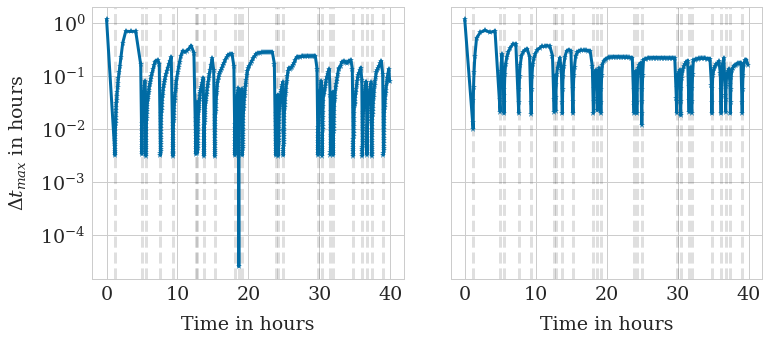

In [8]:
colors = [defcolors[0], defcolors[5], defcolors[6]]

# Combine into single figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey='row', gridspec_kw={'hspace':0.2, 'wspace': 0.15})
#fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey='row', gridspec_kw={'hspace':0.2, 'wspace': 0.15})


force = 'cubic'

try:
    os.remove('step_sizes'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('time_points'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('AFs'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')

ts, history = models_ef[force].simulate(cell_list, t_data, params[force], {"eps": 0.001, "eta":0.0001, "out": filename_ending[force], 'write_to_file': True, 'jacobian': models_ef[force].jacobian, 'force_args': params[force]}, seed=seed)
dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')

n_cells = [len(clt) for clt in history]
division_time_indices = np.where(np.diff(n_cells) == 1)[0]
division_times = np.array(ts)[division_time_indices]
for xc in division_times:
    ax1.axvline(x=xc, color='black', linestyle="--", alpha=0.125)
    
ax1.semilogy(ts[:-1],  dts[:,0],'-*')
ax1.set(xlabel='Time in hours')
ax1.set(ylabel='$\Delta t_{max}$ in hours')
#ax1.legend()

try:
    os.remove('step_sizes'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('time_points'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('AFs'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')

ts, history = models_ef[force].simulate(cell_list, t_data, params[force], {"eps": 0.01, "eta":0.0001, "out": filename_ending[force], 'write_to_file': True, 'jacobian': models_ef[force].jacobian, 'force_args': params[force], 'local_adaptivity': True, 'switch':False}, seed=seed)
dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')

n_cells = [len(clt) for clt in history]
division_time_indices = np.where(np.diff(n_cells) == 1)[0]
division_times = np.array(ts)[division_time_indices]
for xc in division_times:
    ax2.axvline(x=xc, color='black', linestyle="--", alpha=0.125)
    
ax2.semilogy(ts[:-1],  dts,'-*')
ax2.set(xlabel='Time in hours')
#ax2.set(ylabel='$\Delta t_{max}$ in hours')

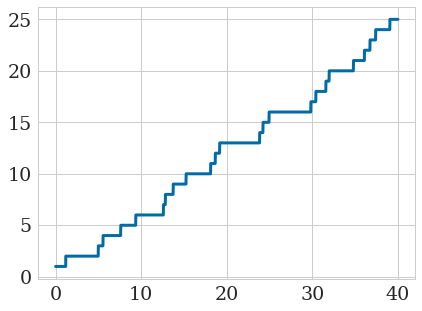

In [9]:
plt.plot(ts, [len(clt) for clt in history ])

In [18]:
dts

array([1.18399633, 0.01010314, 0.01332006, 0.03578222, 0.06272376,
       0.11726457, 0.2386379 , 0.52175377, 0.67319511, 0.73104608,
       0.67321907, 0.71662237, 0.02129444, 0.03648088, 0.0659184 ,
       0.12645639, 0.26018636, 0.04444937, 0.01978417, 0.03258263,
       0.05828227, 0.10905243, 0.1681373 , 0.22936765, 0.28865858,
       0.34728344, 0.40343347, 0.40929248, 0.01996562, 0.03258427,
       0.05733305, 0.1012086 , 0.16053639, 0.23610609, 0.28250698,
       0.3098069 , 0.32878187, 0.22806895, 0.01944401, 0.03181564,
       0.05610641, 0.09984162, 0.16711636, 0.21845889, 0.26722286,
       0.31250044, 0.33781023, 0.36376228, 0.3671736 , 0.37768927,
       0.36839844, 0.24435138, 0.02131558, 0.0364286 , 0.06885705,
       0.10117671, 0.02211887, 0.03948474, 0.07144477, 0.10876592,
       0.14460002, 0.17730157, 0.22230097, 0.12884375, 0.0197193 ,
       0.03208559, 0.05722438, 0.09941833, 0.15604259, 0.23117032,
       0.29860109, 0.31516809, 0.29461695, 0.01988949, 0.03333

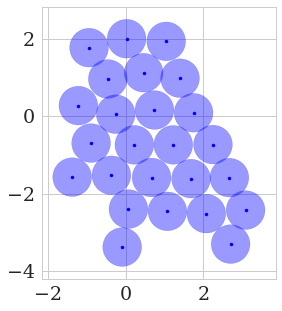

In [10]:
plot_population(history[-1])

In [16]:
%%time 
ts, history = models_ef[force].simulate(cell_list, t_data, params[force], {"eps": 0.001, "eta":0.0001, 'jacobian': models_ef[force].jacobian, 'force_args': params[force]}, seed=seed)


CPU times: user 2.2 s, sys: 72.7 ms, total: 2.27 s
Wall time: 2.53 s


In [17]:
%%time 
ts, history = models_ef[force].simulate(cell_list, t_data, params[force], {"eps": 0.001, "eta":0.0001, 'jacobian': models_ef[force].jacobian, 'force_args': params[force], 'local_adaptivity': True}, seed=seed)


CPU times: user 745 ms, sys: 15.9 ms, total: 761 ms
Wall time: 919 ms


In [27]:
%%time 
ts, history = models_ef[force].simulate(cell_list, t_data, params[force], {'dt': 0.003}, seed=seed)


CPU times: user 1.65 s, sys: 91.8 ms, total: 1.74 s
Wall time: 1.97 s


In [28]:
%%time 
ts, history = models_ef[force].simulate(cell_list, t_data, params[force], {"eps": 0.001, "eta":0.0001}, seed=seed)


CPU times: user 219 ms, sys: 0 ns, total: 219 ms
Wall time: 370 ms


In [19]:
0.01/4

0.0025

In [22]:
try:
    os.remove('step_sizes'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')

In [23]:
ts, history = models_ef[force].simulate(cell_list, t_data, params[force], {"eps": 0.001, "eta":0.0001, "out": filename_ending[force], 'write_to_file': True, 'jacobian': models_ef[force].jacobian, 'force_args': params[force]}, seed=seed)


In [24]:
dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')


In [26]:
dts[:,0]

array([1.18399633e+00, 3.19489371e-03, 3.51394984e-03, 3.87229811e-03,
       4.27575565e-03, 4.73115754e-03, 5.24656504e-03, 5.83152341e-03,
       6.49738302e-03, 7.25770169e-03, 8.12875266e-03, 9.13017073e-03,
       1.02857814e-02, 1.16246753e-02, 1.31826152e-02, 1.50039036e-02,
       1.71438962e-02, 1.96724447e-02, 2.26787089e-02, 2.62780489e-02,
       3.06221906e-02, 3.59147593e-02, 4.24360605e-02, 5.05847169e-02,
       6.09521848e-02, 7.44667974e-02, 9.27004372e-02, 1.18609544e-01,
       1.58677011e-01, 2.31170043e-01, 4.24348533e-01, 7.05220085e-01,
       6.98299372e-01, 7.05220043e-01, 1.66896030e-01, 3.36184920e-03,
       3.71533048e-03, 4.11449428e-03, 4.56643358e-03, 5.07954499e-03,
       5.66380995e-03, 6.33114660e-03, 7.09585347e-03, 7.97517295e-03,
       8.99001303e-03, 1.01657395e-02, 1.15283037e-02, 1.31191327e-02,
       1.49859994e-02, 1.71895239e-02, 1.98077953e-02, 2.29432531e-02,
       2.67332718e-02, 3.13670432e-02, 3.70695094e-02, 4.41472109e-02,
      